In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
Full_data= pd.read_csv('/content/drive/My Drive/summitminds/Merged_data.csv')
Full_data.head()

,Unnamed: 0,customerBillingAddress,customerDevice,customerEmail,customerIPAddress,customerPhone,fraudulent,orderAmount,orderId,orderShippingAddress,orderState,transactionId,paymentMethodId,transactionAmount,transactionFailed,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
0,0,"5493 Jones Islands\r\nBrownside, CA 51896",yyeiaxpltf82440jnb3v,josephhoward@yahoo.com,8.129.104.40,400-108-5415,False,18,vjbdvd,"5493 Jones Islands\r\nBrownside, CA 51896",pending,a9lcj51r,wt07xm68b,18,False,True,card,JCB 16 digit,Citizens First Banks
1,1,"5493 Jones Islands\r\nBrownside, CA 51896",yyeiaxpltf82440jnb3v,josephhoward@yahoo.com,8.129.104.40,400-108-5415,False,26,yp6x27,"5493 Jones Islands\r\nBrownside, CA 51896",fulfilled,y4wcv03i,wt07xm68b,26,False,True,card,JCB 16 digit,Citizens First Banks
2,2,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True,45,nlghpa,"898 Henry Ports\r\nNew Keithview, CA 95893-2497",fulfilled,5mi94sfw,41ug157xz,45,False,False,bitcoin,American Express,Bastion Banks
3,3,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True,23,uw0eeb,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,fulfilled,br8ba1nu,41ug157xz,23,False,False,bitcoin,American Express,Bastion Banks
4,4,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True,43,bn44oh,"5093 Bryan Forks\r\nJoshuaton, FM 01565-9801",fulfilled,a33145ss,y3xp697jx,43,True,True,bitcoin,VISA 16 digit,Solace Banks


In [0]:
Full_data=Full_data.iloc[:,1:]
Fcols=list(Full_data.columns)

In [6]:
print(Fcols)

print("Dtypes:",Full_data.dtypes)

['customerBillingAddress', 'customerDevice', 'customerEmail', 'customerIPAddress', 'customerPhone', 'fraudulent', 'orderAmount', 'orderId', 'orderShippingAddress', 'orderState', 'transactionId', 'paymentMethodId', 'transactionAmount', 'transactionFailed', 'paymentMethodRegistrationFailure', 'paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer']
Dtypes: customerBillingAddress              object
customerDevice                      object
customerEmail                       object
customerIPAddress                   object
customerPhone                       object
fraudulent                            bool
orderAmount                          int64
orderId                             object
orderShippingAddress                object
orderState                          object
transactionId                       object
paymentMethodId                     object
transactionAmount                    int64
transactionFailed                     bool
paymentMethodRegistrationFail

In [7]:

for i in Fcols:
  if Full_data[i].dtype =="object":
    Full_data[i]=Full_data[i].astype('category')

print(Full_data.dtypes)

customerBillingAddress              category
customerDevice                      category
customerEmail                       category
customerIPAddress                   category
customerPhone                       category
fraudulent                              bool
orderAmount                            int64
orderId                             category
orderShippingAddress                category
orderState                          category
transactionId                       category
paymentMethodId                     category
transactionAmount                      int64
transactionFailed                       bool
paymentMethodRegistrationFailure        bool
paymentMethodType                   category
paymentMethodProvider               category
paymentMethodIssuer                 category
dtype: object


In [0]:
Cat_cols=list(Full_data.columns[Full_data.dtypes=="category"])

Cat_cols.remove('orderState')


Bool_cols=list(Full_data.columns[Full_data.dtypes=="bool"])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in Bool_cols:
  Full_data[i]=le.fit_transform(Full_data[i])



In [0]:
Full_data=pd.get_dummies(Full_data,columns=['orderState'])


In [0]:
X=Full_data[Full_data.columns[Full_data.columns != "fraudulent"]]
Y=Full_data["fraudulent"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)


Feature importance

In [0]:
from sklearn.feature_extraction import FeatureHasher
import copy
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
All_features=list(X_train.columns)
Precision={}
for feature in Cat_cols:
  
  X_train_hash = copy.copy(X_train[feature])
  X_test_hash = copy.copy(X_test[feature])

  
  h = FeatureHasher(n_features=1000,input_type="string")
  X_train_hash = h.transform(X_train_hash.values)
  X_test_hash = h.transform(X_test_hash.values)

  #model
  gnb = GaussianNB()
  gnb.fit(X_train_hash.toarray(), y_train)
  y_pred = gnb.predict(X_test_hash.toarray())

  Precision[feature]=precision_score(y_test, y_pred, average='weighted')
  

intcol=list(X_train.columns[X_train.dtypes!='category'])
for feature in intcol:
  #model
  gnb = GaussianNB()
  gnb.fit(X_train_hash.toarray(), y_train)
  y_pred = gnb.predict(X_test_hash.toarray())
  Precision[feature]=precision_score(y_test, y_pred, average='weighted')

  




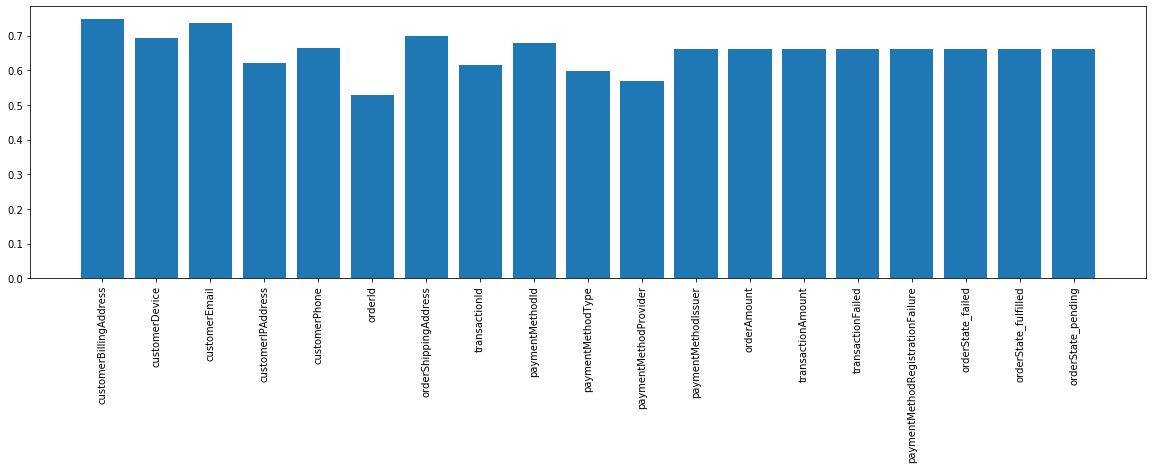

In [22]:
# ploting importance precision as metric
fig= plt.figure(figsize=(20,5))
plt.bar(range(len(Precision)),list(Precision.values()), align='center')
plt.xticks(range(len(Precision)), list(Precision.keys()),rotation='vertical')
plt.show()

**Model with all available features**

In [0]:

X_train_hash = copy.copy(X_train)
X_test_hash = copy.copy(X_test)

for i in range(X_train_hash.shape[1]):
    X_train_hash.iloc[:,i]=X_train_hash.iloc[:,i].astype('str')
for i in range(X_test_hash.shape[1]):
    X_test_hash.iloc[:,i]=X_test_hash.iloc[:,i].astype('str')
h = FeatureHasher(n_features=10000,input_type="string")
X_train_hash = h.transform(X_train_hash.values)
X_test_hash = h.transform(X_test_hash.values)

X_train_hash=pd.DataFrame(X_train_hash.toarray())
X_test_hash=pd.DataFrame(X_test_hash.toarray())

App_trainX=X_train.drop(columns=Cat_cols)
App_testX=X_test.drop(columns=Cat_cols)



In [0]:
X_train_hash=App_trainX.join(X_train_hash)
X_test_hash=App_testX.join(X_test_hash)


In [25]:
X_train_hash.fillna(method="ffill",inplace=True)
X_test_hash.fillna(method="ffill",inplace=True)
X_test_hash.fillna(0,inplace=True)
X_train_hash.isna().sum()
X_test_hash.isna().sum()

orderAmount                         0
transactionAmount                   0
transactionFailed                   0
paymentMethodRegistrationFailure    0
orderState_failed                   0
                                   ..
9995                                0
9996                                0
9997                                0
9998                                0
9999                                0
Length: 10007, dtype: int64

In [0]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_hash, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test_hash)

Classification Report of the model


In [27]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model classification report
print("Classification report:",)
print(metrics.classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        79
           1       0.35      0.65      0.46        46

    accuracy                           0.43       125
   macro avg       0.48      0.48      0.43       125
weighted avg       0.51      0.43      0.42       125

